In [1]:
import os
import gc
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from pandas_profiling import ProfileReport

%matplotlib inline

In [2]:
def pie_chart_by_feature(data, feature):

    plt.figure(figsize=(10, 6))

    data[feature].value_counts().plot(
        kind='pie', label=f'{feature}',
        autopct='%.2f%%', pctdistance=1.3,
        labeldistance=1.1
    )
    plt.legend()
    plt.axis('equal')
    plt.show()

Проведем <b>валидацию данных</b> для последующего обучения модели. Посмотрим на достаточность, непротиворечивость данных и признаков.

In [3]:
train_target = pd.read_csv('train_target.csv')
train_target.shape

(963811, 3)

In [4]:
train_target.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [5]:
train_target.app_id.unique().shape[0]

963811

Видим, что разметка по всем 963811 клиентам присутствует

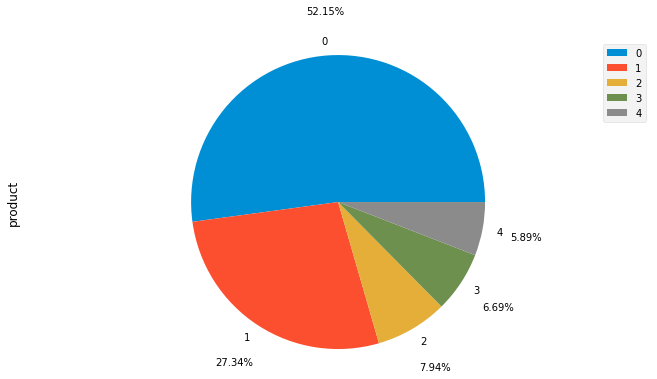

In [6]:
pie_chart_by_feature(train_target, 'product')

В датасете присутсвуют данные и разметка по тагретам по 5 продуктам

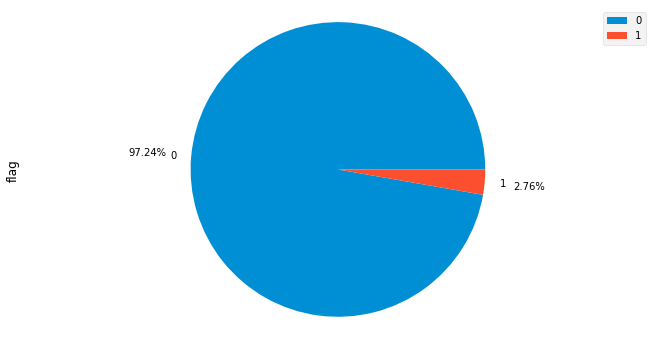

In [7]:
pie_chart_by_feature(train_target, 'flag')

Видим, что доля невозврата близка к реальной(жизненной) - 2.76%. Данные несбалансированы, исходя из этого необходимо с умом производить выбор метрик, правильно обучать модели.

In [8]:
path = 'train_transactions'
all_files = sorted(glob.glob(os.path.join(path, '*.parquet')))
print(all_files[:5])

['train_transactions/part_000_0_to_23646.parquet', 'train_transactions/part_001_23647_to_47415.parquet', 'train_transactions/part_002_47416_to_70092.parquet', 'train_transactions/part_003_70093_to_92989.parquet', 'train_transactions/part_004_92990_to_115175.parquet']


В распакованном архиве с данными содержатся сжатые клиентские данные в формате parquet

In [9]:
%%time

data_from_each_file = (pd.read_parquet(f) for f in all_files)
concatenated_data = pd.concat(data_from_each_file, ignore_index=True)

CPU times: user 55.9 s, sys: 38.6 s, total: 1min 34s
Wall time: 55 s


In [10]:
concatenated_data.to_parquet(
    'transactions_data.parquet.gzip',
    index=False,
    compression='gzip')

In [11]:
concatenated_data.shape

(270450065, 20)

Сконкатенировав все данные в один файл (датафрейм), получаем, что в тренировочной выборке содержатся данные о 270 млн. финансовых транзакций. Это более чем достаточно, для того чтобы построенная модель обладала хорошей обобщающей способностью, не сильно переобучалась и приносила прибыль банку/МФО/платежной системе

In [12]:
concatenated_data.iloc[:5]

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5


Видим, что данные обезличены. С точки зрения построения реальных моделей, Data Scientistы могут запросить расшифровку категориальных переменных, обратную нормализацию суммы транзакции по отдельному защищенному каналу.

In [13]:
concatenated_data.app_id.unique().shape[0]

963811

Подтверждаем, что данные фич не потерялись. Shape таргетов и признаков совпадает

#### Распишем описание признаков транзакционных данных, посмотрим на типы переменных, и кол-во уникальных значений.

- <b>`app_id`</b> - Идентификатор заявки. заявки пронумерованы так, что более поздним заявкам соответствует более поздняя дата
- <b>`amnt`</b> - Нормированная сумма транзакции. 0.0 - соответствует пропускам 
- <b>`currency`</b> - Идентификатор валюты транзакции
- <b>`operation_kind`</b> - Идентификатор типа транзакции
- <b>`card_type`</b> - Уникальный идентификатор типа карты
- <b>`operation_type`</b> - Идентификатор типа операции по пластиковой карте
- <b>`operation_type_group`</b> - Идентификатор группы карточных операций, например, дебетовая карта или кредитная карта
- <b>`ecommerce_flag`</b> - Признак электронной коммерции
- <b>`payment_system`</b> - Идентификатор типа платежной системы
- <b>`income_flag`</b> - Признак списания/внесения денежных средств на карту
- <b>`mcc`</b> - Уникальный идентификатор типа торговой точки
- <b>`country`</b> - Идентификатор страны транзакции
- <b>`city`</b> - Идентификатор города транзакции
- <b>`mcc_category`</b> - Идентификатор категории магазина транзакции
- <b>`day_of_week`</b> - День недели, когда транзакция была совершена
- <b>`hour`</b> - Час, когда транзакция была совершена
- <b>`days_before`</b> - Количество дней до даты выдачи кредита
- <b>`weekofyear`</b> - Номер недели в году, когда транзакция была совершена
- <b>`hour_diff`</b> - Количество часов с момента прошлой транзакции для данного клиента
- <b>`transaction_number`</b> - Порядковый номер транзакции клиента

In [14]:
concatenated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270450065 entries, 0 to 270450064
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   app_id                int32  
 1   amnt                  float64
 2   currency              int32  
 3   operation_kind        int32  
 4   card_type             int32  
 5   operation_type        int32  
 6   operation_type_group  int32  
 7   ecommerce_flag        int32  
 8   payment_system        int32  
 9   income_flag           int32  
 10  mcc                   int32  
 11  country               int32  
 12  city                  int32  
 13  mcc_category          int32  
 14  day_of_week           int32  
 15  hour                  int32  
 16  days_before           int32  
 17  weekofyear            int32  
 18  hour_diff             int64  
 19  transaction_number    int32  
dtypes: float64(1), int32(18), int64(1)
memory usage: 22.2 GB


In [15]:
concatenated_data.nunique()

app_id                   963811
amnt                    3823337
currency                     11
operation_kind                7
card_type                   173
operation_type               22
operation_type_group          4
ecommerce_flag                3
payment_system                7
income_flag                   3
mcc                         108
country                      24
city                        163
mcc_category                 28
day_of_week                   7
hour                         24
days_before                 359
weekofyear                   53
hour_diff                  6345
transaction_number         9580
dtype: int64

Видим, что кол-во уникальных значений переменных соответсвтует действительности. Есть несколько основных категорий MCC по которым клиенты Альфа Банка производят покупки; operation_type может быть нескольких видов - POS покупка, ECOM, перевод, CASH_IN, CASH_OUT, нефинансовый тип, и т.д. Флаг ecommerce_flag скорее всего принимает значения - {0, 1, NA} и говорит нам была ли эта транзакция ECOM.

In [16]:
gc.collect()

6022